In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [52]:
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [53]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root = dataset_path, transform=transform)

In [54]:
class_names = dataset.classes
class_names

['Blazer',
 'Celana_Panjang',
 'Celana_Pendek',
 'Gaun',
 'Hoodie',
 'Jaket',
 'Jaket_Denim',
 'Jaket_Olahraga',
 'Jeans',
 'Kaos',
 'Kemeja',
 'Mantel',
 'Polo',
 'Rok',
 'Sweter']

In [55]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(5625, 1875)

In [56]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [57]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [58]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60491073..1.8083708].


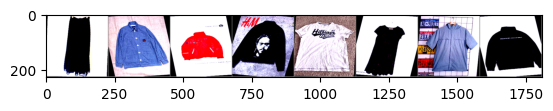

In [21]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images[:8]))

In [22]:
[dataset.classes[i] for i in labels[:8]]

['Rok',
 'Jaket_Denim',
 'Jaket',
 'Jaket_Denim',
 'Kaos',
 'Gaun',
 'Jaket',
 'Jaket']

In [26]:
class_names = dataset.classes
class_names

['Blazer',
 'Celana_Panjang',
 'Celana_Pendek',
 'Gaun',
 'Hoodie',
 'Jaket',
 'Jaket_Denim',
 'Jaket_Olahraga',
 'Jeans',
 'Kaos',
 'Kemeja',
 'Mantel',
 'Polo',
 'Rok',
 'Sweter']

In [27]:
num_classes = len(class_names)
num_classes

15

In [30]:
class ClothesClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2 , padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.network(x)

In [38]:
def train_model(model, criterion, optimizer, epochs = 5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epochs: { epoch+1}, loss: {loss.item():.2f}")

            running_loss += loss.item()* images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        print(f"Epochs: {epoch+1}/{epochs}, Epoch_loss: {epoch_loss:.4f}")

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                 images, labels = images.to(device), labels.to(device)
                 outputs = model(images)
                 _, predicted = torch.max(outputs.data,1)
                 total += labels.size(0)
                 correct += (predicted == labels).sum().item()
                 all_labels.extend(labels.cpu().numpy())
                 all_predictions.extend(predicted.cpu().numpy())

        print(f"*** validation accuracy: { 100 * correct / total:.2f}")

    end = time.time()
    print(f" Exection time: { end - start} seconds")

    return all_labels, all_predictions

In [39]:
model = ClothesClassifier(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epochs: 1, loss: 2.74
Batch: 20, Epochs: 1, loss: 2.66
Batch: 30, Epochs: 1, loss: 2.70
Batch: 40, Epochs: 1, loss: 2.70
Batch: 50, Epochs: 1, loss: 2.67
Batch: 60, Epochs: 1, loss: 2.70
Batch: 70, Epochs: 1, loss: 2.68
Batch: 80, Epochs: 1, loss: 2.66
Batch: 90, Epochs: 1, loss: 2.57
Batch: 100, Epochs: 1, loss: 2.73
Batch: 110, Epochs: 1, loss: 2.56
Batch: 120, Epochs: 1, loss: 2.35
Batch: 130, Epochs: 1, loss: 2.45
Batch: 140, Epochs: 1, loss: 2.42
Batch: 150, Epochs: 1, loss: 2.48
Batch: 160, Epochs: 1, loss: 2.45
Batch: 170, Epochs: 1, loss: 2.33
Epochs: 1/5, Epoch_loss: 2.6033
*** validation accuracy: 25.23
Batch: 10, Epochs: 2, loss: 2.33
Batch: 20, Epochs: 2, loss: 2.24
Batch: 30, Epochs: 2, loss: 2.27
Batch: 40, Epochs: 2, loss: 2.26
Batch: 50, Epochs: 2, loss: 2.29
Batch: 60, Epochs: 2, loss: 2.28
Batch: 70, Epochs: 2, loss: 2.24
Batch: 80, Epochs: 2, loss: 2.10
Batch: 90, Epochs: 2, loss: 2.05
Batch: 100, Epochs: 2, loss: 2.17
Batch: 110, Epochs: 2, loss: 2.08
Bat

In [40]:
import torchvision.models as models

model = models.efficientnet_b0(weights = 'DEFAULT')
model.classifier[1].in_features

1280

In [42]:
class ClothesClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad=False
        
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features ,num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [43]:
model = ClothesClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epochs: 1, loss: 2.68
Batch: 20, Epochs: 1, loss: 2.52
Batch: 30, Epochs: 1, loss: 2.23
Batch: 40, Epochs: 1, loss: 2.22
Batch: 50, Epochs: 1, loss: 2.03
Batch: 60, Epochs: 1, loss: 2.11
Batch: 70, Epochs: 1, loss: 2.01
Batch: 80, Epochs: 1, loss: 1.69
Batch: 90, Epochs: 1, loss: 1.90
Batch: 100, Epochs: 1, loss: 1.77
Batch: 110, Epochs: 1, loss: 1.76
Batch: 120, Epochs: 1, loss: 1.71
Batch: 130, Epochs: 1, loss: 1.60
Batch: 140, Epochs: 1, loss: 1.53
Batch: 150, Epochs: 1, loss: 1.43
Batch: 160, Epochs: 1, loss: 1.38
Batch: 170, Epochs: 1, loss: 1.48
Epochs: 1/10, Epoch_loss: 1.9560
*** validation accuracy: 58.24
Batch: 10, Epochs: 2, loss: 1.59
Batch: 20, Epochs: 2, loss: 1.45
Batch: 30, Epochs: 2, loss: 1.49
Batch: 40, Epochs: 2, loss: 1.31
Batch: 50, Epochs: 2, loss: 1.58
Batch: 60, Epochs: 2, loss: 1.25
Batch: 70, Epochs: 2, loss: 1.41
Batch: 80, Epochs: 2, loss: 1.89
Batch: 90, Epochs: 2, loss: 1.19
Batch: 100, Epochs: 2, loss: 1.72
Batch: 110, Epochs: 2, loss: 1.37
Ba

In [ ]:
class ClothesClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

In [47]:
model = ClothesClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10 )

Batch: 10, Epochs: 1, loss: 2.28
Batch: 20, Epochs: 1, loss: 1.63
Batch: 30, Epochs: 1, loss: 1.08
Batch: 40, Epochs: 1, loss: 1.37
Batch: 50, Epochs: 1, loss: 1.03
Batch: 60, Epochs: 1, loss: 1.48
Batch: 70, Epochs: 1, loss: 1.06
Batch: 80, Epochs: 1, loss: 1.10
Batch: 90, Epochs: 1, loss: 0.91
Batch: 100, Epochs: 1, loss: 1.06
Batch: 110, Epochs: 1, loss: 0.92
Batch: 120, Epochs: 1, loss: 1.02
Batch: 130, Epochs: 1, loss: 0.93
Batch: 140, Epochs: 1, loss: 0.71
Batch: 150, Epochs: 1, loss: 0.78
Batch: 160, Epochs: 1, loss: 1.05
Batch: 170, Epochs: 1, loss: 0.79
Epochs: 1/10, Epoch_loss: 1.1825
*** validation accuracy: 73.17
Batch: 10, Epochs: 2, loss: 0.72
Batch: 20, Epochs: 2, loss: 0.99
Batch: 30, Epochs: 2, loss: 0.56
Batch: 40, Epochs: 2, loss: 0.56
Batch: 50, Epochs: 2, loss: 0.43
Batch: 60, Epochs: 2, loss: 0.53
Batch: 70, Epochs: 2, loss: 0.63
Batch: 80, Epochs: 2, loss: 0.84
Batch: 90, Epochs: 2, loss: 0.77
Batch: 100, Epochs: 2, loss: 0.74
Batch: 110, Epochs: 2, loss: 1.28
Ba

In [51]:
torch.save(model.state_dict(), 'saved_model.pth')